In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# シンプルなニューラルネットワークを作る
class SimpleMNISTNet(nn.Module):
    def __init__(self):
        super(SimpleMNISTNet, self).__init__()
        # 28x28=784ピクセル → 128 → 64 → 10クラス
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 画像を1次元に変換
        x = x.view(-1, 784)
        # 活性化関数ReLUを適用
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # 最後は活性化しない（CrossEntropyLossが内部でやる）
        x = self.fc3(x)
        return x

# モデルを作成
model = SimpleMNISTNet()
print(model)  # 構造を確認


SimpleMNISTNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データの前処理（正規化）
transform = transforms.Compose([
    transforms.ToTensor(),  # 画像をTensorに変換
    transforms.Normalize((0.1307,), (0.3081,))  # 平均と標準偏差で正規化
])

# MNISTデータセットをダウンロード＆読み込み
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoaderでバッチ処理
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# データの形を確認
images, labels = next(iter(train_loader))
print(f"Batch画像の形: {images.shape}")  # torch.Size([64, 1, 28, 28])
print(f"Batchラベルの形: {labels.shape}")  # torch.Size([64])


Batch画像の形: torch.Size([64, 1, 28, 28])
Batchラベルの形: torch.Size([64])


In [15]:
import torch.optim as optim

# 損失関数（CrossEntropyLoss）
criterion = nn.CrossEntropyLoss()

# オプティマイザー（SGD or Adam）
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# または
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# 試しに1バッチだけ学習してみる
model.train()  # 学習モードに
images, labels = next(iter(train_loader))

# 順伝播
outputs = model(images)
loss = criterion(outputs, labels)
print(f"初期Loss: {loss.item()}")

# 逆伝播
optimizer.zero_grad()  # 勾配をリセット
loss.backward()  # 勾配を計算
optimizer.step()  # パラメータを更新

# もう一度同じバッチで計算
outputs = model(images)
loss = criterion(outputs, labels)
print(f"1回更新後のLoss: {loss.item()}")  # 少し下がったはず！


初期Loss: 2.278205394744873
1回更新後のLoss: 2.272482395172119


In [17]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 勾配をリセット
        optimizer.zero_grad()

        # 順伝播
        output = model(data)
        loss = criterion(output, target)

        # 逆伝播
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 100バッチごとに進捗を表示
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]'
                  f'\tLoss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [18]:
# デバイスの設定（GPU使えるなら使う）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleMNISTNet().to(device)

In [19]:
# 1エポック学習してみる
train_loss = train(model, device, train_loader, optimizer, criterion, epoch=1)
print(f'平均Loss: {train_loss:.4f}')

Epoch: 1 [0/60000]	Loss: 2.336213
Epoch: 1 [6400/60000]	Loss: 2.272260
Epoch: 1 [12800/60000]	Loss: 2.357660
Epoch: 1 [19200/60000]	Loss: 2.340219
Epoch: 1 [25600/60000]	Loss: 2.341530
Epoch: 1 [32000/60000]	Loss: 2.337468
Epoch: 1 [38400/60000]	Loss: 2.311916
Epoch: 1 [44800/60000]	Loss: 2.322774
Epoch: 1 [51200/60000]	Loss: 2.313268
Epoch: 1 [57600/60000]	Loss: 2.321685
平均Loss: 2.3219


In [16]:
# Day 5/6 のコードの続きとして追記
train_losses = []  # 訓練時の平均Lossを記録
test_accuracies = [] # テスト時の精度を記録
test_losses = [] # テスト時の平均Lossも記録しておくと、後で過学習の確認に便利です

In [21]:
def test(model, device, test_loader, criterion):
    model.eval()  # 評価モードに
    test_loss = 0
    correct = 0

    with torch.no_grad():  # 勾配計算しない（高速化）
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            # 予測クラスを取得
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.2f}%)')

    return test_loss, accuracy

# テストしてみる
test_loss, accuracy = test(model, device, test_loader, criterion)


Test Loss: 2.3223, Accuracy: 920/10000 (9.20%)


In [22]:
# Day 6 実装ブロックの実行部分
# 訓練実行
train_loss = train(model, device, train_loader, optimizer, criterion, epoch=1)
print(f'平均Loss: {train_loss:.4f}')

# ★ 訓練結果を記録
train_losses.append(train_loss)

# テスト実行 (test関数は test_loss と accuracy を返すように定義しています)
test_loss, accuracy = test(model, device, test_loader, criterion)

# ★ テスト結果を記録
test_losses.append(test_loss)
test_accuracies.append(accuracy)

print("記録完了！")

Epoch: 1 [0/60000]	Loss: 2.304996
Epoch: 1 [6400/60000]	Loss: 2.339753
Epoch: 1 [12800/60000]	Loss: 2.309123
Epoch: 1 [19200/60000]	Loss: 2.317438
Epoch: 1 [25600/60000]	Loss: 2.299537
Epoch: 1 [32000/60000]	Loss: 2.321652
Epoch: 1 [38400/60000]	Loss: 2.300834
Epoch: 1 [44800/60000]	Loss: 2.343469
Epoch: 1 [51200/60000]	Loss: 2.343442
Epoch: 1 [57600/60000]	Loss: 2.324081
平均Loss: 2.3219
Test Loss: 2.3223, Accuracy: 920/10000 (9.20%)
記録完了！


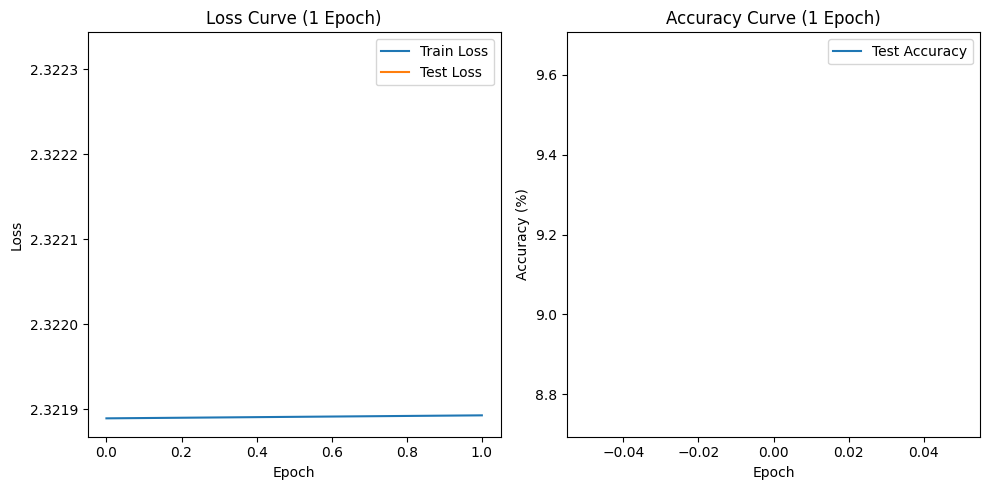

In [23]:
import matplotlib.pyplot as plt

# 損失（Loss）の推移をプロット
plt.figure(figsize=(10, 5))

# 訓練LossとテストLossの推移
plt.subplot(1, 2, 1) # 1行2列の1つ目
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve (1 Epoch)')

# 精度（Accuracy）の推移をプロット
plt.subplot(1, 2, 2) # 1行2列の2つ目
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve (1 Epoch)')

plt.tight_layout()
plt.show()